# Phase 1: Classification (assign Utility, Application, or Entity Tag)

In [193]:
version = "v_team" # All options: v_imen, v_team
systems = ["cargotracker", "pos", "jforum", "petclinic"]
model_type = "codebert" # All options: ft_codebert, word2vec, albert, codebert, roberta, bert

## 1.1 Create Embeddings

In [194]:
from transformers import AutoTokenizer, AutoModel, AlbertTokenizer, AlbertModel, RobertaModel, RobertaTokenizer, BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from utils import load_class_code_from_directory, load_data_from_csv, write_embeddings_to_csv, associate_classes_to_types
from embeddings import generate_embeddings_for_java_code, generate_word_embeddings_for_java_code
import nltk
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api

In [195]:
# Check if CUDA (GPU) is available and if so, set the device to GPU
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev)

In [196]:
# Select the model and tokenizer
if (model_type == "codebert"):
    tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base",force_download=False)
    model = AutoModel.from_pretrained("microsoft/codebert-base",force_download=False)
elif (model_type == "ft_codebert"):
    tokenizer = AutoTokenizer.from_pretrained("./codebert_finetuned",force_download=False)
    model = AutoModel.from_pretrained("./codebert_finetuned",force_download=False)
elif (model_type == "bert"):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") 
    model = BertModel.from_pretrained("bert-base-uncased") 
elif (model_type == "roberta"):
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    model = RobertaModel.from_pretrained("roberta-base")
elif (model_type == "albert"): 
    # pip3 install sentencepiece
    tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
    model = AlbertModel.from_pretrained("albert-base-v2")
elif model_type == "word2vec":
    # Download required NLTK datasets and initialize the lemmatizer
    nltk.download('wordnet')
    word_lemmatizer = WordNetLemmatizer()

    # Load Word2Vec model
    word2vec_model = api.load('word2vec-google-news-300')
else:
    raise NameError("model type not supported")

# Move the model to the GPU if available
model = model.to(device)

**Association des étiquettes sur les classes de TOUT les projets**

In [199]:
for system in systems:
    # Labels are 0: Application, 1: Utility, 2: Entity
    class_labels = associate_classes_to_types(version, system)
    print(f"Processing system: {system}, number of classes: {len(class_labels)}")

    # For each class in class_code, generate embeddings and add to class_embeddings dictionary
    class_embeddings = {}
    class_code = load_class_code_from_directory(system)
    if model_type == "word2vec":
        class_embeddings = {class_name: generate_word_embeddings_for_java_code(code, word2vec_model, word_lemmatizer) for class_name, code in class_code.items()}
    else:
        class_embeddings = {class_name: generate_embeddings_for_java_code(code, model, tokenizer, device) for class_name, code in class_code.items()}

    # Write embeddings to csv file
    write_embeddings_to_csv(version, system, model_type, class_embeddings, class_labels)

Token indices sequence length is longer than the specified maximum sequence length for this model (1424 > 512). Running this sequence through the model will result in indexing errors


Processing system: cargotracker, number of classes: 109
Processing system: pos, number of classes: 55
Processing system: jforum, number of classes: 241
Processing system: petclinic, number of classes: 39


## 1.2 Train classifiers

In [200]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt

## Préparation des données d'entrainement et de tests

In [201]:
training_systems = ["jforum", "cargotracker", "petclinic"]
test_systems = ["pos"]

**Préparation des données d'entrainement**

In [202]:
training_embeddings = []
training_labels = []
training_class_names = []

for system in training_systems:
    # Load data
    filename = f"./generated_data/embedding/{version}_{system}_{model_type}_embeddings.csv"
    class_names, labels, embeddings = load_data_from_csv(filename)

    training_embeddings.extend(embeddings)
    training_labels.extend(labels)
    training_class_names.extend(class_names)

# We use the combined arrays, no split anymore
Xtrain = np.array(training_embeddings)
ytrain = np.array(training_labels)

# Ensure at least one instance of each class in the training data
unique_classes = set(labels)
for cls in unique_classes:
    if cls not in ytrain:
        cls_index = labels.index(cls)
        Xtrain = np.vstack([Xtrain, [embeddings[cls_index]]])
        ytrain.append(cls)

# Calculate class frequencies and mean frequency
class_freq = Counter(ytrain)
mean_count = sum(class_freq.values()) // len(class_freq)

# Identify classes that need resampling (e.g., significantly fewer than mean_count)
threshold = 0.7  # 70% of the mean_count
classes_to_resample = {cls: int(mean_count) for cls, count in class_freq.items() if count < mean_count * threshold}

# Check if all classes_to_resample have enough samples
skip_resampling = False
for class_label in classes_to_resample.keys():
    if class_label in class_freq and class_freq[class_label] < 2:  # k_neighbors + 1
        skip_resampling = True
        print(f"Skipping resampling for class {class_label} due to insufficient samples.")
        break

# Apply SMOTE
if not skip_resampling and classes_to_resample:
    sm = SMOTE(sampling_strategy=classes_to_resample, k_neighbors=1, random_state=42)
    Xtrain, ytrain = sm.fit_resample(Xtrain, ytrain)

print(f'Number of classes: {len(training_class_names)}\nResampled dataset shape: {Counter(ytrain)}')
print(f'len(Xtrain): {len(Xtrain)}')
print(f'ytrain: {ytrain}')
print(f'ytrain count: {np.bincount(ytrain)}')

Number of classes: 387
Resampled dataset shape: Counter({0: 162, 2: 122, 1: 103})
len(Xtrain): 387
ytrain: [0 1 0 0 2 0 1 0 2 1 2 0 2 2 1 0 0 1 0 0 0 0 1 0 0 0 0 2 1 2 1 2 2 0 2 2 2
 0 1 2 1 0 0 0 0 2 0 1 2 2 2 0 2 0 1 0 1 0 1 1 2 2 2 0 0 1 1 1 2 2 1 2 0 0
 2 2 1 0 1 0 2 0 2 2 1 0 1 0 1 0 0 1 2 2 0 2 2 0 0 1 1 1 2 0 0 0 0 1 2 1 0
 0 1 1 1 2 0 0 0 2 0 1 0 2 1 2 1 2 1 1 1 1 0 0 0 1 0 2 1 0 1 0 0 1 2 0 2 2
 0 0 1 0 0 1 0 1 2 1 1 0 0 1 2 0 0 2 0 1 2 1 1 0 0 0 0 1 1 0 0 2 2 1 2 0 2
 2 1 1 2 2 1 0 0 1 2 2 0 0 0 0 0 1 2 0 0 1 2 0 1 1 2 2 0 1 0 1 0 0 1 0 2 1
 1 1 0 2 2 2 1 0 1 0 0 0 2 1 1 2 2 1 2 0 0 2 2 2 0 1 2 0 2 2 0 1 0 2 0 0 1
 0 2 2 1 0 2 2 0 2 0 1 2 0 1 0 0 1 2 1 2 0 2 0 2 2 0 0 0 2 0 0 1 0 0 0 2 2
 1 0 0 1 2 1 2 0 2 0 0 0 0 2 2 2 2 2 0 0 0 0 1 0 0 2 0 2 1 0 1 2 2 1 0 0 2
 2 1 0 0 1 0 0 1 2 2 2 0 0 0 2 0 0 2 0 2 2 0 1 2 2 0 2 2 0 2 2 1 1 0 1 2 0
 0 0 0 1 2 0 2 1 1 1 0 2 0 0 2 1 0]
ytrain count: [162 103 122]


**Préparation des données de test**

In [203]:
test_embeddings = []
test_labels = []
test_class_names = []

for system in test_systems:
    # Load data
    filename = f"./generated_data/embedding/{version}_{system}_{model_type}_embeddings.csv"
    class_names, labels, embeddings = load_data_from_csv(filename)

    test_embeddings.extend(embeddings)
    test_labels.extend(labels)
    test_class_names.extend(class_names)

Xtest = np.array(test_embeddings)
ytest = np.array(test_labels)

print(f'Number of classes: {len(test_class_names)}\nResampled dataset shape: {Counter(ytest)}')
print(f'len(Xtest): {len(Xtest)}')
print(f'ytest: {ytest}')
print(f'ytest count: {np.bincount(ytest)}')

Number of classes: 55
Resampled dataset shape: Counter({0: 29, 2: 23, 1: 3})
len(Xtest): 55
ytest: [0 2 2 0 2 0 2 0 2 2 0 0 2 0 2 2 2 2 0 2 0 0 1 2 0 0 0 2 0 2 2 0 2 0 0 0 0
 0 0 0 0 0 0 1 0 2 2 2 2 2 0 1 0 2 0]
ytest count: [29  3 23]


In [204]:
print(f'total class types repartition : {np.bincount(ytrain) + np.bincount(ytest)}')

total class types repartition : [191 106 145]


In [206]:
# # OPTIONAL: Please keep this code commented out unless you want to use it
# # This code ensures that each class is represented in the test set, proportional to its representation in the training set
# # Calculate class frequencies for training and test sets
# train_class_freq = Counter(ytrain)
# test_class_freq = Counter(ytest)

# # Calculate the ratio between the size of the training and test sets
# ratio = len(ytrain) / len(ytest)

# # Iterate over each class to make sure it has proportional representation in the test set
# for cls, train_count in train_class_freq.items():
#     expected_test_count = int(train_count / ratio)
#     actual_test_count = test_class_freq.get(cls, 0)

#     if actual_test_count < expected_test_count:
#         # Find instances in the training set to move to the test set
#         for _ in range(expected_test_count - actual_test_count):
#             cls_index = ytrain.index(cls)
#             Xtest = np.vstack([Xtest, [Xtrain[cls_index]]])
#             ytest.append(cls)
#             Xtrain = np.delete(Xtrain, cls_index, axis=0)
#             ytrain.pop(cls_index)

## Génération des rapports de classification (version textuelle)

In [207]:
def generate_classification_report(y_true, y_pred):
    # Identify unique labels in both true labels and predictions
    unique_labels = np.unique(np.concatenate((y_true, y_pred)))

    # Map unique labels to their corresponding names
    label_names_map = {-1: "None", 0: "Application", 1: "Utility", 2: "Entity"}
    dynamic_label_names = [label_names_map[label] for label in unique_labels]

    # Generate and print the classification report
    print(classification_report(y_true, y_pred, target_names=dynamic_label_names, zero_division=1))

## Génération des fichiers CSV pour la classification de chaque modèle et modèle de prédiction

In [208]:
import os
import pandas as pd

In [209]:
def generate_classification_report_to_csv(y_true, y_pred, model_name, embedding_model):

    csv_file = f'generated_data/visualization/classification_reports_{embedding_model}.csv'

    unique_labels = np.unique(np.concatenate((y_true, y_pred)))
    label_names_map = {-1: "None", 0: "Application", 1: "Utility", 2: "Entity"}
    dynamic_label_names = [label_names_map[label] for label in unique_labels]
    
    report = classification_report(y_true, y_pred, target_names=dynamic_label_names, output_dict=True, zero_division=1)
    
    # Create a DataFrame from the report
    new_data = pd.DataFrame(report).transpose().reset_index()
    new_data.columns = ['label', 'precision', 'recall', 'f1-score', 'support']
    new_data['model_name'] = model_name
    
    # If CSV file exists and is non-empty, load it and filter out old model data
    if os.path.exists(csv_file) and os.path.getsize(csv_file) > 0:
        existing_data = pd.read_csv(csv_file)
        # Filter out the old data for the current model
        existing_data = existing_data[existing_data['model_name'] != model_name]
    else:
        existing_data = pd.DataFrame()

    # Concatenate new data with existing data
    combined_data = pd.concat([existing_data, new_data], ignore_index=True)

    # Save the combined data back to CSV
    combined_data.to_csv(csv_file, index=False)

## Class types repartition representation

In [210]:
def visualize_counts(ytrain_count, ytest_count):
    # Map unique labels to their corresponding names
    label_names_map = {-1: "None", 0: "Application", 1: "Utility", 2: "Entity"}
    labels = [label_names_map[i] for i in range(len(ytrain_count))]

    # Colors for each bar
    colors_train = ['lightblue', 'lightgreen', 'lightcoral']
    colors_test = ['blue', 'green', 'red']

    # Generate the histogram
    plt.bar(labels, ytrain_count, color=colors_train, label='ytrain')
    plt.bar(labels, ytest_count, bottom=ytrain_count, color=colors_test, label='ytest')
    
    plt.ylabel('Count')
    plt.title(f'Total type repartition')
    plt.legend()
    plt.show()

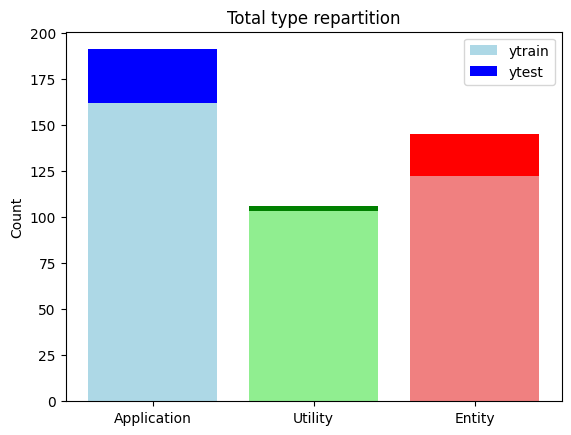

In [211]:
visualize_counts(np.bincount(ytrain), np.bincount(ytest))

## Génération d'histogramme pour la répartition des élèments par classe par modèle de prédiction

In [212]:
def generate_classification_report_for_types(y_true, y_pred, prediction_model_name):
    # Map unique labels to their corresponding names
    label_names_map = {-1: "None", 0: "Application", 1: "Utility", 2: "Entity"}

    # Generate the classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

    # Extract support values
    supports = [report[str(key)]['support'] for key in sorted(report.keys())[:-3]]
    labels = [label_names_map[int(key)] for key in sorted(report.keys())[:-3]]

    # Colors for each bar
    colors = ['blue', 'green', 'red']

    # Generate the histogram
    plt.bar(labels, supports, color=colors)
    plt.ylabel('Number of classes')
    plt.title(f'Type repartition using {prediction_model_name}')
    plt.show()

## Decision Tree

0.6363636363636364
[[21  0  8]
 [ 3  0  0]
 [ 9  0 14]]
              precision    recall  f1-score   support

 Application       0.64      0.72      0.68        29
     Utility       1.00      0.00      0.00         3
      Entity       0.64      0.61      0.62        23

    accuracy                           0.64        55
   macro avg       0.76      0.44      0.43        55
weighted avg       0.66      0.64      0.62        55



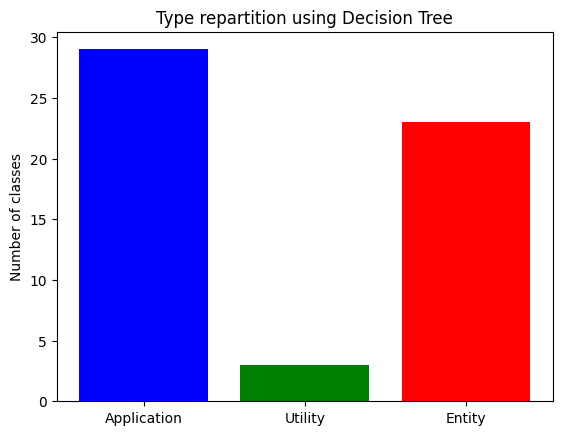

In [213]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=2).fit(Xtrain, ytrain)
decision_tree_predictions = decision_tree_classifier.predict(Xtest)
decision_tree_accuracy = accuracy_score(ytest, decision_tree_predictions)
decision_tree_confusion_matrix = confusion_matrix(ytest, decision_tree_predictions)
print(decision_tree_accuracy)
print(decision_tree_confusion_matrix)
generate_classification_report(ytest, decision_tree_predictions)
generate_classification_report_for_types(ytest, decision_tree_predictions, "Decision Tree")
generate_classification_report_to_csv(ytest, decision_tree_predictions, "decision_tree", model_type)

## SVM

SVM Accuracy: 0.7272727272727273
[[22  0  7]
 [ 1  2  0]
 [ 5  2 16]]
              precision    recall  f1-score   support

 Application       0.79      0.76      0.77        29
     Utility       0.50      0.67      0.57         3
      Entity       0.70      0.70      0.70        23

    accuracy                           0.73        55
   macro avg       0.66      0.71      0.68        55
weighted avg       0.73      0.73      0.73        55



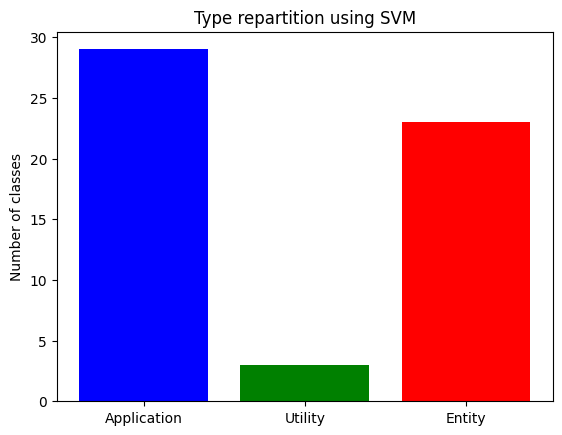

In [214]:
svm_classifier = SVC(kernel='linear', C=2, probability=True).fit(Xtrain, ytrain)
svm_predictions = svm_classifier.predict(Xtest)
svm_accuracy = accuracy_score(ytest, svm_predictions)
svm_confusion_matrix = confusion_matrix(ytest, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")
print(svm_confusion_matrix)
generate_classification_report(ytest, svm_predictions)
generate_classification_report_for_types(ytest, svm_predictions, "SVM")
generate_classification_report_to_csv(ytest, svm_predictions, "svm", model_type)

## KNN

0.6727272727272727
[[21  0  8]
 [ 3  0  0]
 [ 5  2 16]]
              precision    recall  f1-score   support

 Application       0.72      0.72      0.72        29
     Utility       0.00      0.00      1.00         3
      Entity       0.67      0.70      0.68        23

    accuracy                           0.67        55
   macro avg       0.46      0.47      0.80        55
weighted avg       0.66      0.67      0.72        55



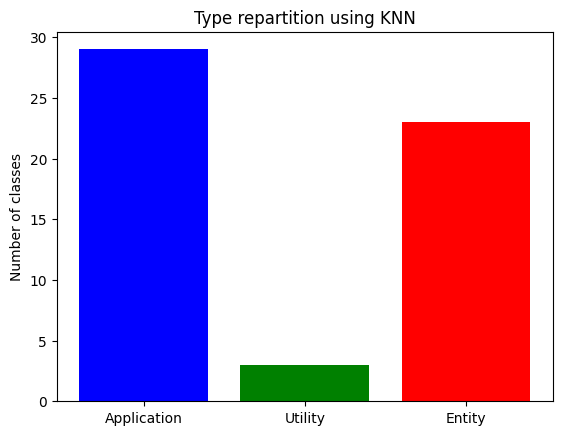

In [215]:
knn_classifier = KNeighborsClassifier(n_neighbors=5).fit(Xtrain, ytrain)
knn_predictions = knn_classifier.predict(Xtest)
knn_accuracy = accuracy_score(ytest, knn_predictions)
knn_confusion_matrix = confusion_matrix(ytest, knn_predictions)
print(knn_accuracy)
print(knn_confusion_matrix)
generate_classification_report(ytest, knn_predictions)
generate_classification_report_for_types(ytest, knn_predictions, "KNN")
generate_classification_report_to_csv(ytest, knn_predictions, "knn", model_type)

## LogisticRegression

0.7454545454545455
[[22  0  7]
 [ 1  2  0]
 [ 6  0 17]]
              precision    recall  f1-score   support

 Application       0.76      0.76      0.76        29
     Utility       1.00      0.67      0.80         3
      Entity       0.71      0.74      0.72        23

    accuracy                           0.75        55
   macro avg       0.82      0.72      0.76        55
weighted avg       0.75      0.75      0.75        55



/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


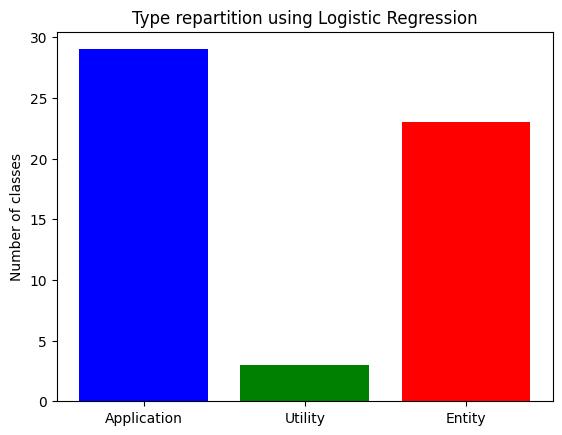

In [216]:
logistic_regression_classifier = LogisticRegression(random_state=0).fit(Xtrain, ytrain)
logistic_regression_predictions = logistic_regression_classifier.predict(Xtest)
logistic_regression_accuracy = accuracy_score(ytest, logistic_regression_predictions)
logistic_regression_confusion_matrix = confusion_matrix(ytest, logistic_regression_predictions)
print(logistic_regression_accuracy)
print(logistic_regression_confusion_matrix)
generate_classification_report(ytest, logistic_regression_predictions)
generate_classification_report_for_types(ytest, logistic_regression_predictions, "Logistic Regression")
generate_classification_report_to_csv(ytest, logistic_regression_predictions, "logistic_regression", model_type)

## Gaussian NB

0.6363636363636364
[[22  7  0]
 [ 2  0  1]
 [ 4  6 13]]
              precision    recall  f1-score   support

 Application       0.79      0.76      0.77        29
     Utility       0.00      0.00      1.00         3
      Entity       0.93      0.57      0.70        23

    accuracy                           0.64        55
   macro avg       0.57      0.44      0.82        55
weighted avg       0.80      0.64      0.76        55



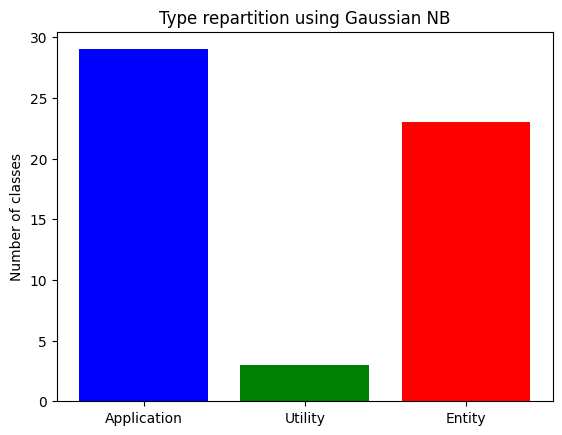

In [217]:
naive_bayes_classifier = GaussianNB().fit(Xtrain, ytrain)
naive_bayes_predictions = naive_bayes_classifier.predict(Xtest)
naive_bayes_accuracy = accuracy_score(ytest, naive_bayes_predictions)
naive_bayes_confusion_matrix = confusion_matrix(ytest, naive_bayes_predictions)
print(naive_bayes_accuracy)
print(naive_bayes_confusion_matrix)
generate_classification_report(ytest, naive_bayes_predictions)
generate_classification_report_for_types(ytest, naive_bayes_predictions, "Gaussian NB")
generate_classification_report_to_csv(ytest, naive_bayes_predictions, "gaussian_nb", model_type)

## Ensemble learning

/Library/Python/3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Python/3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7090909090909091
[[22  0  7]
 [ 2  1  0]
 [ 5  2 16]]
              precision    recall  f1-score   support

 Application       0.76      0.76      0.76        29
     Utility       0.33      0.33      0.33         3
      Entity       0.70      0.70      0.70        23

    accuracy                           0.71        55
   macro avg       0.60      0.60      0.60        55
weighted avg       0.71      0.71      0.71        55



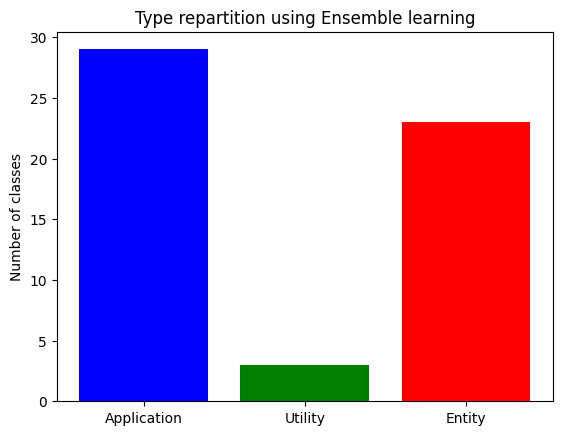

In [218]:
# Combine individual classifiers into an ensemble
ensemble_clf = VotingClassifier(estimators=[
('svm', svm_classifier), ('knn', knn_classifier), ('dt', decision_tree_classifier), ('log_reg', logistic_regression_classifier), ('gnb', naive_bayes_classifier)],
voting='soft')

# Use SVM as the base estimator for AdaBoost
svm_base = SVC(kernel='linear', C=2, probability=True) # Can use any other classifier as the base estimator
ada_boost = AdaBoostClassifier(base_estimator=svm_base, n_estimators=50, algorithm='SAMME.R', random_state=1)

# Combine the ensemble classifier with AdaBoost
final_ensemble = VotingClassifier(estimators=[
    ('ensemble_clf', ensemble_clf), ('ada_boost', ada_boost)],
    voting='soft')

# Fit model to your data
final_ensemble.fit(Xtrain, ytrain)

# Evaluate model
ensemble_predictions = final_ensemble.predict(Xtest)
ensemble_accuracy = accuracy_score(ytest, ensemble_predictions)
print('Accuracy:', ensemble_accuracy)
ensemble_confusion_matrix = confusion_matrix(ytest, ensemble_predictions)
print(ensemble_confusion_matrix)
generate_classification_report(ytest, ensemble_predictions)
generate_classification_report_for_types(ytest, ensemble_predictions, "Ensemble learning")
generate_classification_report_to_csv(ytest, ensemble_predictions, "ensemble_learning", model_type)